In [32]:
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import date,datetime,timedelta
import os,requests,urllib3,shutil,zipfile

In [33]:
# Example of the BigFire GeoServer API for obtaining weather forecasts from specific models

In [34]:
def GetForecastData(model,ndays,var,bnd,minusdays=0,basedir="./"):
    print(GetBounds(bnd))

    # Download the data file from the GeoServer
    # Note: Need to make date ranges dynamic
    url=MakeWCSRequest(model=model,ndays=ndays,var=var,bnd=bnd,minusdays=minusdays)

    print(url)
    #Suppress Python ssl warnings:
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

    #Make the request for the data with SSL verification disabled:
    data = requests.get(url,verify=False)
    # To save to an absolute path.
    fn = f'{basedir}/{model}_{var}.nc'
    with open(fn, 'wb') as f:
        f.write(data.content)
    return fn

# Note: This function was found and reused to help with the Error 406 I was getting from the Natural Earth download
# It requires the request to send a header first so the server can interpret the request
def download_file(url,local_filename):
    #local_filename = url.split('/')[-1]
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    # NOTE the stream=True parameter below
    with requests.get(url, headers=headers,stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                # If you have chunk encoded response uncomment if
                # and set chunk_size parameter to None.
                #if chunk: 
                f.write(chunk)
    return local_filename

def GetTimeRange(ndays,minusdays=0):
            
    curdate = date.today() + timedelta(days=-minusdays)
    curdateo = curdate
    curdate = curdate.isoformat()
    enddate = curdateo+ timedelta(days=ndays)

    curisodate = f"{curdate}T00:00:00Z"
    curisodateend = f"{enddate.isoformat()}T23:59:59Z"
    drange = f"\"{curisodate}\",\"{curisodateend}\""
    return drange

# Pass a GeoPandas dataframe and get back the bounding box
def GetBounds(zone_aoi):
    # Get lat min, max
    aoi_lat = [float(zone_aoi.total_bounds[1]), float(zone_aoi.total_bounds[3])]
    aoi_lon = [float(zone_aoi.total_bounds[0]), float(zone_aoi.total_bounds[2])]
    # Notice that the longitude values have negative numbers
    # we need these values in a global crs so we can subtract from 360
    return aoi_lat, aoi_lon

def MakeWCSRequest(model,ndays,var="Temperature",bnd=None,minusdays=0):
    #var = Temperature, Relative_humidity, Wind_speed, Total_precipitation
    format="application/x-netcdf4"
    # Read the bounding box from the shapefile
    latrange=""
    lonrange=""
    if bnd is not None:
        bnds = GetBounds(bnd)
        latrange = "%s,%s" % (bnds[0][0],bnds[0][1])
        lonrange = "%s,%s" % (bnds[1][0],bnds[1][1])
    else:
        latrange="-18.3479753557,-0.0572054988649"
        lonrange="-81.4109425524,-68.6650797187"
    timerange=GetTimeRange(ndays,minusdays=minusdays)#"\"2021-07-26T00:00:00Z\",\"2021-07-26T23:59:59Z\""
    url = f"https://wfas.firenet.gov/geoserver/{model}/wcs?service=WCS&version=2.0.1&request=GetCoverage&coverageId={var}&subset=Lat({latrange})&subset=Long({lonrange})&subset=time({timerange})&format={format}"
    return url


In [35]:
# Read the Colombia boundary from GADM
co_bnd = gpd.read_file('Data/gadm41_COL.gpkg')

<Axes: >

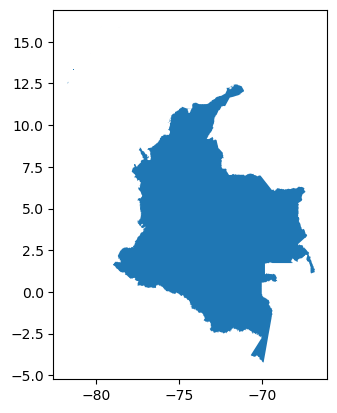

In [36]:
co_bnd.plot()

In [37]:
procbase = '.'
basedir = f"{procbase}/Data"
mychunk = {'latitude':25,'longitude':25,'time': -1}


In [51]:
ndays = 3 #starts at 0, so 2 would return a 3 day forecast 
model = 'gfs'
boundary = co_bnd
# Temperature
fn = GetForecastData(model,ndays,"Temperature",boundary,basedir=basedir)
t = xr.open_dataset(fn)
t.rio.write_crs("epsg:4326",inplace=True)

([-4.228428840999868, 15.912475000000086], [-81.84152999899993, -66.83773803699995])
https://wfas.firenet.gov/geoserver/gfs/wcs?service=WCS&version=2.0.1&request=GetCoverage&coverageId=Temperature&subset=Lat(-4.228428840999868,15.912475000000086)&subset=Long(-81.84152999899993,-66.83773803699995)&subset=time("2024-02-08T00:00:00Z","2024-02-11T23:59:59Z")&format=application/x-netcdf4


<xarray.Dataset>
Dimensions:      (time: 200, lat: 80, lon: 60)
Coordinates:
  * time         (time) datetime64[ns] 2024-02-08 ... 2024-02-22T21:00:00
  * lat          (lat) float32 -4.0 -3.75 -3.5 -3.25 ... 15.0 15.25 15.5 15.75
  * lon          (lon) float32 -81.75 -81.5 -81.25 -81.0 ... -67.5 -67.25 -67.0
    spatial_ref  int32 0
Data variables:
    Temperature  (time, lat, lon) float32 ...
Attributes:
    spatial_ref:   GEOGCS["WGS 84", \n DATUM["World Geodetic System 1984", \n...
    GeoTransform:  -81.75 0.25 0.0 15.75 0.0 -0.25

## Sample the forecast by location....

In [39]:
# Bogota, CO
lat = 4.60971
lon = -74.08175

# Villavicencio, CO
lat = 4.15
lon = -73.633333

# Sample the temperature for the location

In [40]:
t_sel = t.sel(lat=[lat],lon=[lon],method='nearest')
#t_sel

In [41]:
# Summarize to daily 

In [42]:
# You can use any function (max, min, mean, median, etc....,)
t_sel_daily = t_sel.resample(time="D").max('time')

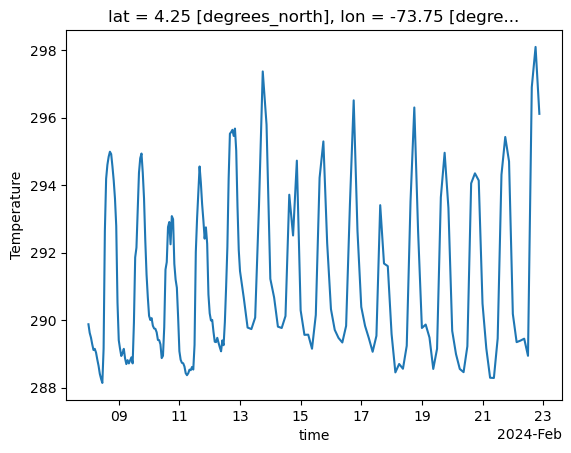

In [43]:
t_sel.Temperature.plot()

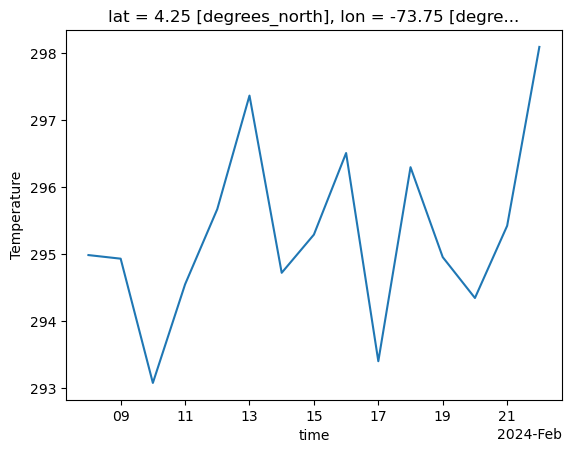

In [44]:
t_sel_daily.Temperature.plot()

<Axes: title={'center': 'time = 2024-02-08, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

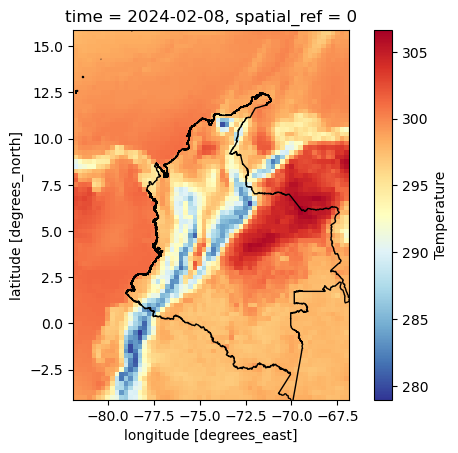

In [45]:
f,ax = plt.subplots()
t.Temperature[0].plot(ax=ax,cmap='RdYlBu_r')
co_bnd.plot(ax=ax,facecolor='none')

In [46]:
# Total precipitation

fn = GetForecastData(model,ndays,"Total_precipitation",boundary,basedir=basedir)
tp = xr.open_dataset(fn)
tp.rio.write_crs("epsg:4326",inplace=True)

([-4.228428840999868, 15.912475000000086], [-81.84152999899993, -66.83773803699995])
https://wfas.firenet.gov/geoserver/gfs/wcs?service=WCS&version=2.0.1&request=GetCoverage&coverageId=Total_precipitation&subset=Lat(-4.228428840999868,15.912475000000086)&subset=Long(-81.84152999899993,-66.83773803699995)&subset=time("2024-02-08T00:00:00Z","2024-02-22T23:59:59Z")&format=application/x-netcdf4


<xarray.Dataset>
Dimensions:              (time: 200, lat: 80, lon: 60)
Coordinates:
  * time                 (time) datetime64[ns] 2024-02-08 ... 2024-02-22T21:0...
  * lat                  (lat) float32 -4.0 -3.75 -3.5 ... 15.25 15.5 15.75
  * lon                  (lon) float32 -81.75 -81.5 -81.25 ... -67.25 -67.0
    spatial_ref          int32 0
Data variables:
    Total_precipitation  (time, lat, lon) float32 ...
Attributes:
    spatial_ref:   GEOGCS["WGS 84", \n DATUM["World Geodetic System 1984", \n...
    GeoTransform:  -81.75 0.25 0.0 15.75 0.0 -0.25

## Summarize forecast to daily totals and extremes

In [47]:
mychunk = {'lat':25,'lon':25,'time':-1}
dailytmax = t.resample(time="D").max('time')
dailyprcp = tp.resample(time="D").sum('time')

In [48]:
dailytmax

<xarray.Dataset>
Dimensions:      (lat: 80, lon: 60, time: 15)
Coordinates:
  * lat          (lat) float32 -4.0 -3.75 -3.5 -3.25 ... 15.0 15.25 15.5 15.75
  * lon          (lon) float32 -81.75 -81.5 -81.25 -81.0 ... -67.5 -67.25 -67.0
    spatial_ref  int32 0
  * time         (time) datetime64[ns] 2024-02-08 2024-02-09 ... 2024-02-22
Data variables:
    Temperature  (time, lat, lon) float32 299.7 299.9 300.3 ... 299.7 299.7
Attributes:
    spatial_ref:   GEOGCS["WGS 84", \n DATUM["World Geodetic System 1984", \n...
    GeoTransform:  -81.75 0.25 0.0 15.75 0.0 -0.25

## Make plots of the daily forecasts

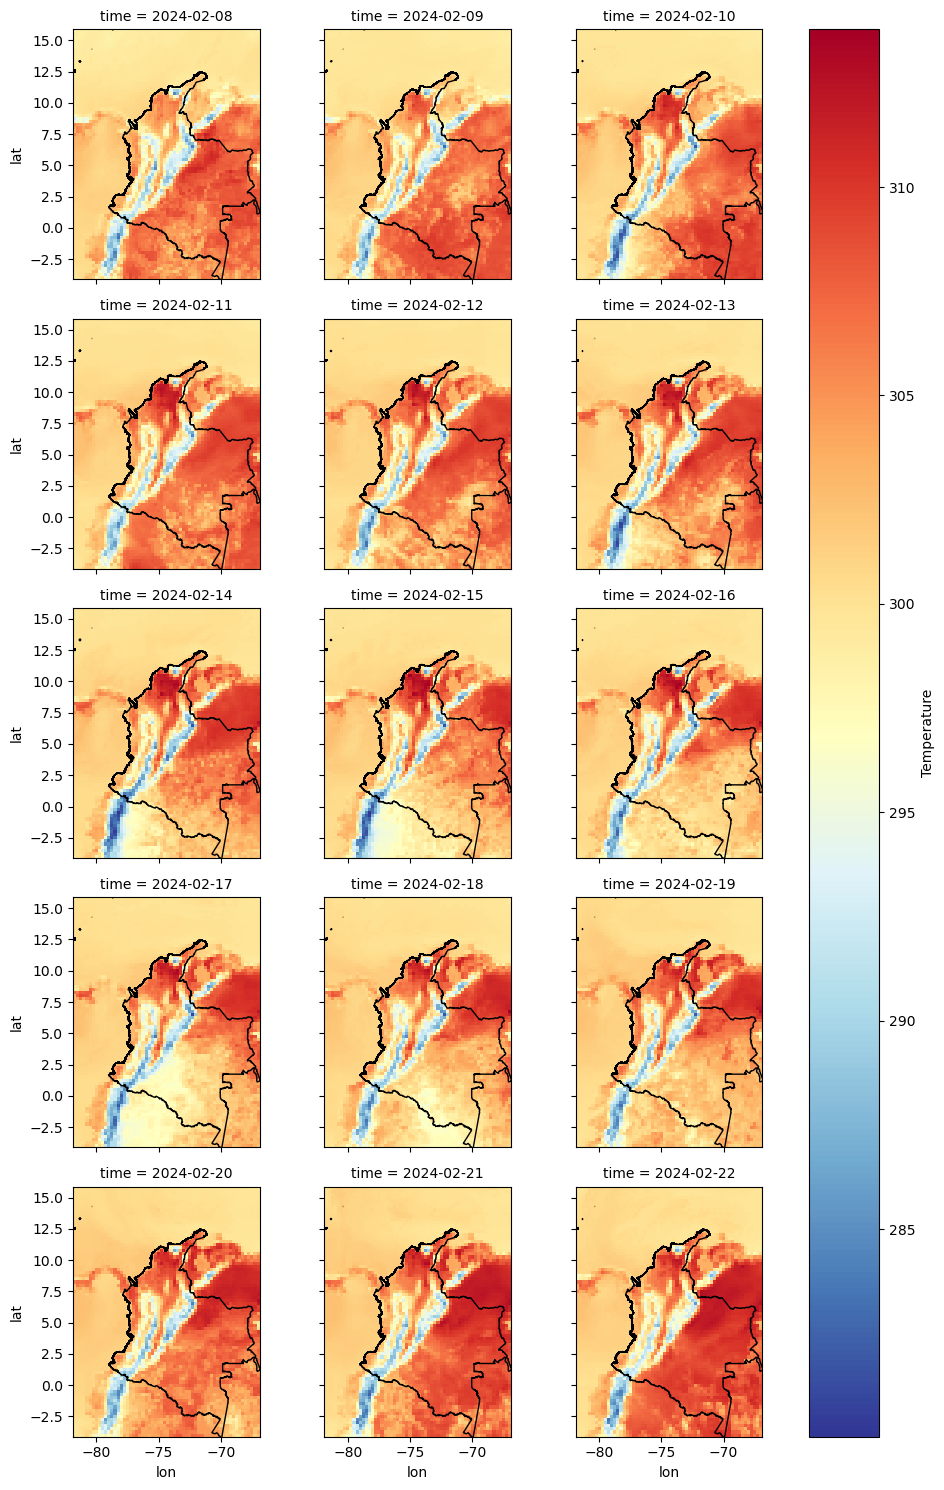

In [49]:
g_simple = dailytmax.Temperature.plot(x="lon", y="lat", col="time", col_wrap=3,cmap='RdYlBu_r')
for a in g_simple.axs.flatten():
    co_bnd.plot(facecolor='none',ax=a)

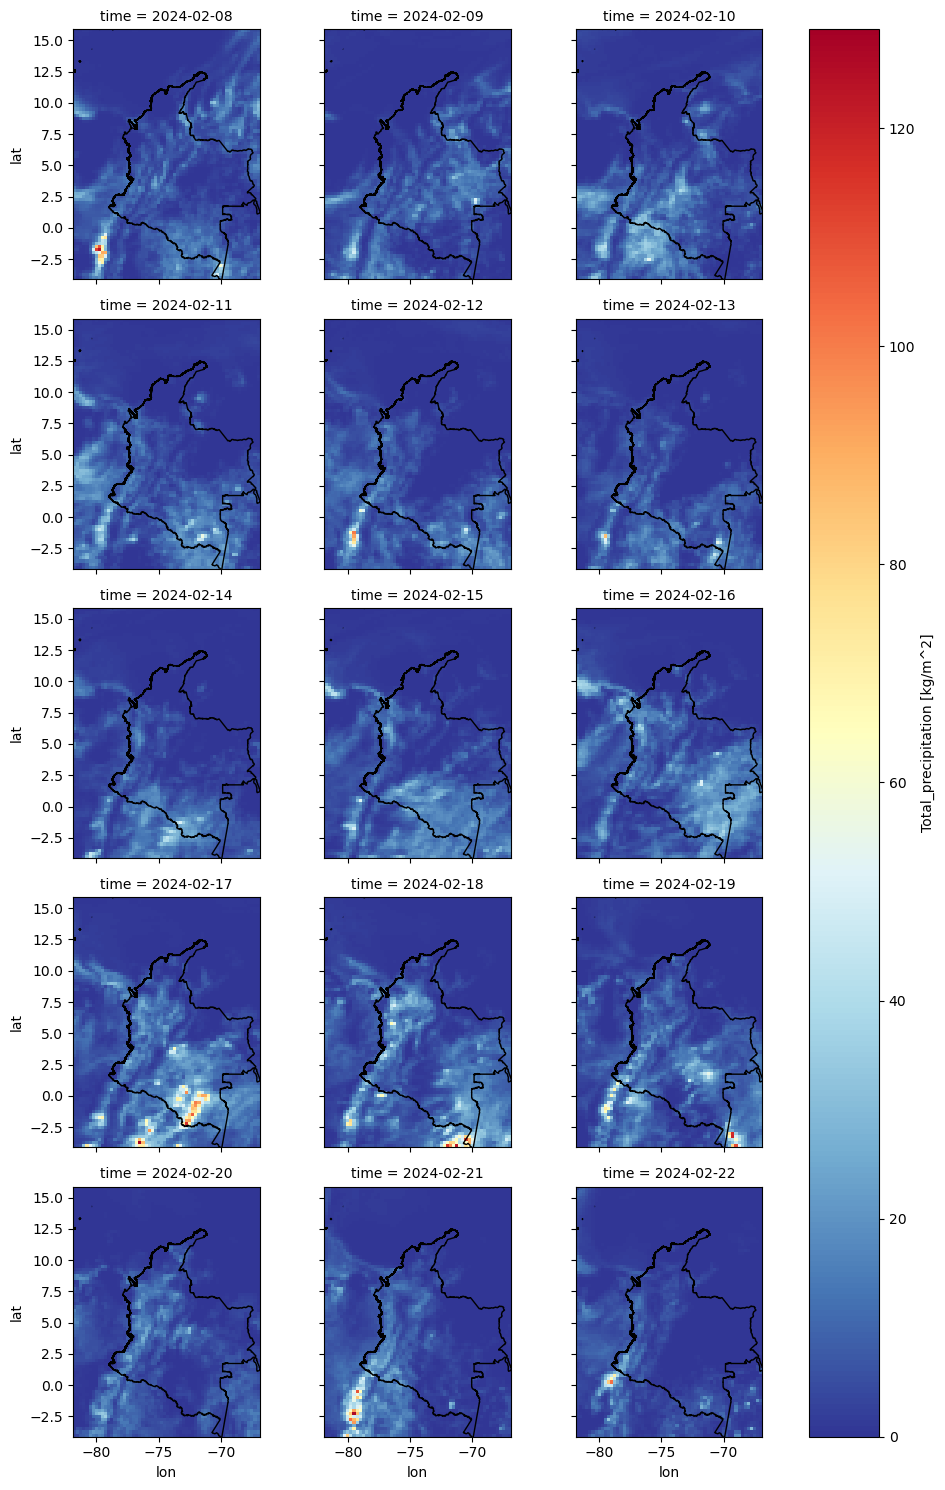

In [50]:
g_simple = dailyprcp.Total_precipitation.plot(x="lon", y="lat", col="time", col_wrap=3,cmap='RdYlBu_r')
for a in g_simple.axs.flatten():
    co_bnd.plot(facecolor='none',ax=a)